In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

import jax
import jax.numpy as jnp

import gpx

import matplotlib.pyplot as plt
plt.style.use("dark_background")

%load_ext autoreload
%autoreload 2

In [2]:
jax.config.x64_enabled

True

In [3]:
train_x = jnp.linspace(0, 1, 100)
key = jax.random.PRNGKey(0)
train_y_1 = jnp.sin(train_x * (2 * jnp.pi)) + jax.random.normal(
    key, shape=train_x.shape
) * jnp.sqrt(0.04)

test_x = jnp.linspace(-0.5, 1.5, 51)
test_f_1 = jnp.sin(test_x * (2 * jnp.pi))

train_y_2 = jnp.sin(train_x*(3*jnp.pi)) + jax.random.normal(key, shape=train_x.shape) * jnp.sqrt(0.04)
test_f_2 = jnp.sin(test_x*(3*jnp.pi))

train_x = train_x.reshape(-1, 1)
train_y = jnp.c_[train_y_1, train_y_2]
test_x = test_x.reshape(-1, 1)
test_f = jnp.c_[test_f_1, test_f_2]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
print('x.shape:', train_x.shape)
print('y.shape:', train_y.shape)

x.shape: (100, 1)
y.shape: (100, 2)


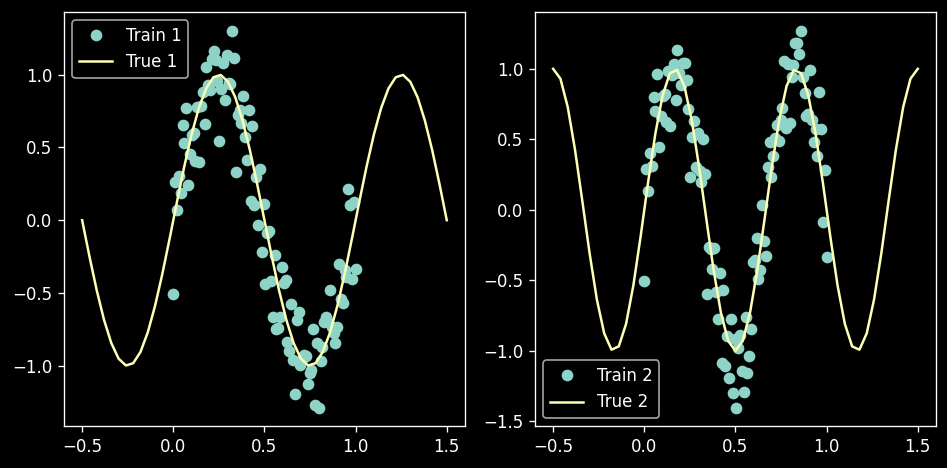

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(4*2, 4), dpi=120)

ax = axes[0]
ax.plot(train_x, train_y[:, 0], "o", label="Train 1")
ax.plot(test_x, test_f[:, 0], label="True 1")

ax = axes[1]
ax.plot(train_x, train_y[:, 1], "o", label="Train 2")
ax.plot(test_x, test_f[:, 1], label="True 2")

for ax in axes:
    ax.legend()

fig.tight_layout()

In [6]:
# instantiate in the same way
model = gpx.models.GPR(
    kernel=gpx.kernels.SquaredExponential(),
)

In [7]:
model.print()

┌────────────────────┬─────────────┬────────────┬──────────────────┬─────────┬─────────┬─────────┐
│ name               │ trainable   │ bijector   │ prior            │ dtype   │ shape   │   value │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼─────────┤
│ kernel lengthscale │ True        │ Softplus   │ Gamma(1.0, 1.0)  │ float64 │ ()      │       1 │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼─────────┤
│ sigma              │ True        │ Softplus   │ Normal(0.0, 1.0) │ float64 │ ()      │       1 │
└────────────────────┴─────────────┴────────────┴──────────────────┴─────────┴─────────┴─────────┘


In [8]:
# hypers and coefficients are fitted considering both
model.fit(train_x, train_y)

In [9]:
model.print()

┌────────────────────┬─────────────┬────────────┬──────────────────┬─────────┬─────────┬──────────┐
│ name               │ trainable   │ bijector   │ prior            │ dtype   │ shape   │    value │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼──────────┤
│ kernel lengthscale │ True        │ Softplus   │ Gamma(1.0, 1.0)  │ float64 │ ()      │ 0.260811 │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼──────────┤
│ sigma              │ True        │ Softplus   │ Normal(0.0, 1.0) │ float64 │ ()      │ 0.309344 │
└────────────────────┴─────────────┴────────────┴──────────────────┴─────────┴─────────┴──────────┘


In [10]:
yhat, cov = model.predict(test_x, full_covariance=True)
err = 2 * jnp.diag(cov) ** 0.5 

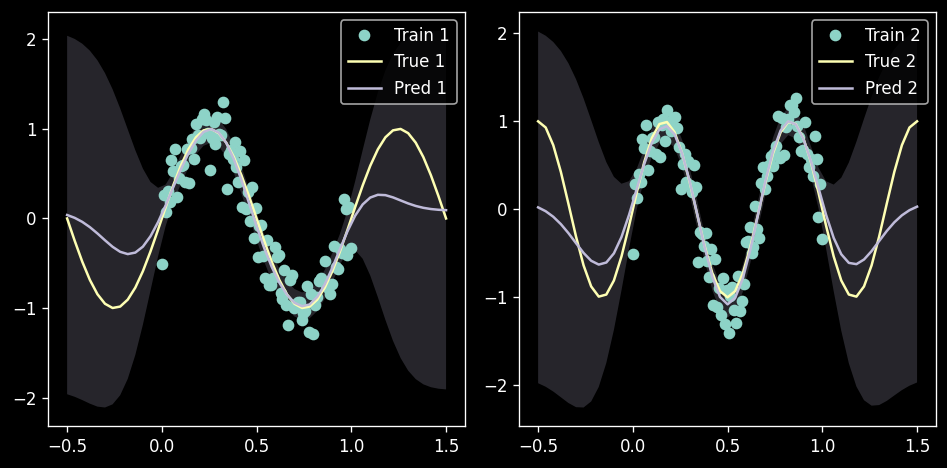

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(4*2, 4), dpi=120)

ax = axes[0]
ax.plot(train_x, train_y[:, 0], "o", label="Train 1")
ax.plot(test_x, test_f[:, 0], label="True 1")
ax.plot(test_x, yhat[:, 0], label="Pred 1")
ax.fill_between(test_x.reshape(-1), yhat[:, 0] - err, yhat[:, 0] + err, alpha=.2, facecolor="C2")

ax = axes[1]
ax.plot(train_x, train_y[:, 1], "o", label="Train 2")
ax.plot(test_x, test_f[:, 1], label="True 2")
ax.plot(test_x, yhat[:, 1], label="Pred 2")
ax.fill_between(test_x.reshape(-1), yhat[:, 1] - err, yhat[:, 1] + err, alpha=.2, facecolor="C2")


for ax in axes:
    ax.legend()

fig.tight_layout()